# Peptide Retention Time Prediction using Encoder-Only Transformer – Evaluation & Test Notebook

This notebook loads a trained Encoder-Only Transformer model and evaluates it on validation/test data, and shows how to predict RT for new peptide sequences.

---

## 1. Setup & Imports

In [1]:
import sys
sys.path.append('./src')

from rt_transformer import AATokenizer, PeptideRTDataset, PeptideRTEncoderModel, split_dataset, collate, compute_metrics

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

import numpy as np

## 2. Configuration
Set data and saved model paths and model hyperparameters (must match training!).

In [ ]:
DATA_PATH = "data/misc_dia.txt"
MODEL_PATH = "models/rt_encoder_model_misc_dia_64_4_5.pt"
D_MODEL = 64
N_HEADS = 4
N_LAYERS = 5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


## 3. Load Data and Model

In [3]:
# Tokenizer and dataset
tokenizer = AATokenizer()
dataset = PeptideRTDataset(DATA_PATH, tokenizer)

# Use the same split as in training
_, val_ds = split_dataset(dataset, val_ratio=0.05, seed=42)
coll = lambda b: collate(b, tokenizer.pad_id)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=coll)

# Model
model = PeptideRTEncoderModel(
    tokenizer,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=4*D_MODEL,
    n_layers=N_LAYERS
)

if torch.cuda.is_available():
    model = nn.DataParallel(model)

model=model.to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
print(f"Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")

Model size: 255938 parameters


## 4. Evaluate on Validation Set

In [4]:
# Get predictions and targets
all_preds, all_targets, all_peptides = [], [], []

with torch.no_grad():
    model.eval()
    for batch in val_loader:
        seqs, mask, rts = batch
        seqs, mask = seqs.to(DEVICE), mask.to(DEVICE)
        preds = model(seqs, mask).cpu().numpy()

        all_preds.append(preds)
        all_targets.append(rts.numpy())

        # Decode each sequence in the batch
        # seqs is a tensor of shape (batch_size, seq_len)
        decoded_batch = [dataset.tok.decode(seq.cpu().tolist()) for seq in seqs]
        all_peptides.extend(decoded_batch)

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

c:\Users\mmakaranka\AppData\Local\pypoetry\Cache\virtualenvs\peptide-rt-transformer-7ashheYG-py3.12\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Compute main metrics.

In [5]:
# Convert numpy arrays to torch tensors
all_preds_torch = torch.tensor(all_preds)
all_targets_torch = torch.tensor(all_targets)

metrics = compute_metrics(all_preds_torch, all_targets_torch)
print("\nValidation metrics for model:")
for k, v in metrics.items():
    print(f"{k:26s}: {v:.5f}")


Validation metrics for model:
MAE                       : 175.76370
MSE                       : 64243.17969
RMSE                      : 253.46239
Max_Abs_Error             : 3479.71191
Median_Abs_Error          : 123.90100
Mean_Abs_Percentage_Error : inf
Std_Error                 : 251.65977
Std_True                  : 2751.13403
Std_Pred                  : 2747.50317
R2                        : 0.99151
Explained_Variance        : 0.99163
Pearson                   : 0.99581
Spearman                  : 0.99701


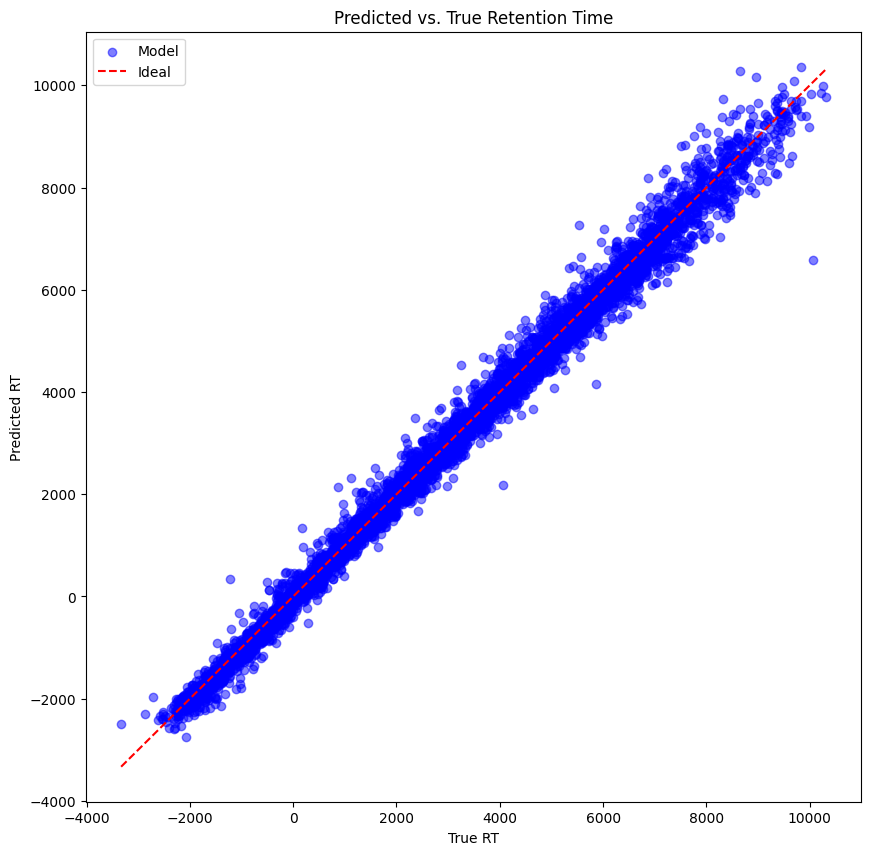

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(all_targets, all_preds, alpha=0.5, label="Model", color="blue")
plt.xlabel("True RT")
plt.ylabel("Predicted RT")
plt.title("Predicted vs. True Retention Time")
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--', label="Ideal")
plt.legend()
plt.show()

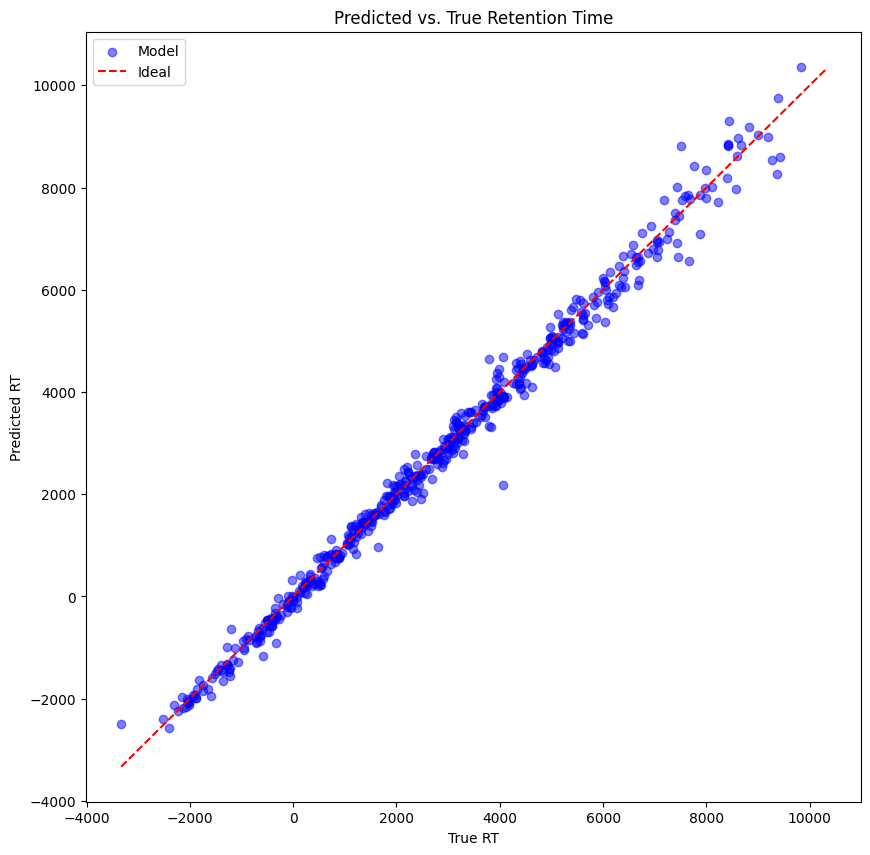

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(all_targets[:552], all_preds[:552], alpha=0.5, label="Model", color="blue")
plt.xlabel("True RT")
plt.ylabel("Predicted RT")
plt.title("Predicted vs. True Retention Time")
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--', label="Ideal")
plt.legend()
plt.show()

## 5. Outliers

In [8]:
# Calculate errors
errors = all_preds - all_targets
abs_errors = np.abs(errors)
outlier_threshold = np.mean(abs_errors) + 2 * np.std(abs_errors)

# Get outliers with peptide information
outliers = []
for i in np.where(abs_errors > outlier_threshold)[0]:
    outliers.append({
        'peptide': all_peptides[i],
        'true_rt': all_targets[i],
        'pred_rt': all_preds[i],
        'error': errors[i],
        'abs_error': abs_errors[i]
    })

# Sort by worst errors
outliers.sort(key=lambda x: x['abs_error'], reverse=True)

# Display results
print(f"{len(outliers)} outliers found out of {len(all_peptides)} data records (threshold: {outlier_threshold:.4f})")
for outlier in outliers:
    print(f"{outlier['peptide']:40} | True: {outlier['true_rt']:.4f} | Pred: {outlier['pred_rt']:.4f} | Error: {outlier['error']:.4f}")

333 outliers found out of 7329 data records (threshold: 541.0049)
VLGITAQNSSGLTCDPGTGHVAYLAGCVVVILDPK      | True: 10068.0000 | Pred: 6588.2881 | Error: -3479.7119
HVMTRLGEKLSDEEVDEMIR                     | True: 4068.0000 | Pred: 2176.0386 | Error: -1891.9614
VLNEAVGALMYHTITLTREDLEK                  | True: 5529.0000 | Pred: 7257.8286 | Error: 1728.8286
HGAEPLPSEDENCTLVEVTEEEVENSVK             | True: 5862.0000 | Pred: 4150.0107 | Error: -1711.9893
VADNLAIQLAAVTEDKYEILQSVDDAAIVIK          | True: 8643.0000 | Pred: 10270.4707 | Error: 1627.4707
LSPAFSQEEDK                              | True: -1230.0000 | Pred: 351.5810 | Error: 1581.5811
VPAFLDLFMQSLFKPGAR                       | True: 8322.0000 | Pred: 9731.8945 | Error: 1409.8945
TIADSLINSFLK                             | True: 6870.0000 | Pred: 8193.6963 | Error: 1323.6963
VFNNVLLQQTQHLDSHGEPTITSLYTNWYLETLLR      | True: 7878.0000 | Pred: 9189.3848 | Error: 1311.3848
GGQLQEQLTQQLSQALSSAVAGR                  | True: 7504.0000 | Pred

## 6. Predict RT for New Peptide Sequences
Enter your own peptide(s) below.

In [9]:
def predict_peptide_rt(peptide_seq, model, tokenizer, device):
    """
    Predict RT for a single peptide sequence (no padding, mask omitted).
    """
    model.eval()
    seq_tensor = tokenizer.encode(peptide_seq).unsqueeze(0).to(device)
    mask = torch.zeros_like(seq_tensor, dtype=torch.bool)  # all False
    with torch.no_grad():
        pred = model(seq_tensor, mask)
    return float(pred.item())

def predict_peptide_batch_rt(peptide_seqs, model, tokenizer, device):
    """
    Predict RTs for a batch of peptide sequences.
    Returns a list of floats.
    """
    model.eval()
    # Encode all sequences (list of tensors of different lengths)
    seqs = [tokenizer.encode(seq) for seq in peptide_seqs]
    # Pad to same length: (batch, max_len)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=tokenizer.pad_id)
    # Mask: True where <pad>
    key_padding_mask = seqs_padded.eq(tokenizer.pad_id)
    seqs_padded, key_padding_mask = seqs_padded.to(device), key_padding_mask.to(device)
    with torch.no_grad():
        preds = model(seqs_padded, key_padding_mask)  # (batch,)
    return preds.cpu().tolist()

# Read all peptides and real RTs from the file
data = []
with open("data\misc_dia.txt", 'r') as f:
    for line in f:
        line = line.strip()
        if line:  # Skip empty lines
            peptide, rt = line.split('\t')
            data.append((peptide, float(rt)))

comparison_data = data[1000:1022]
peptides = [item[0] for item in comparison_data]
real_rts = [item[1] for item in comparison_data]

# ---- Single prediction ----
single_preds = []
for pep in peptides:
    rt_pred = predict_peptide_rt(pep, model, tokenizer, DEVICE)
    single_preds.append(rt_pred)

# ---- Batch prediction ----
batch_preds = predict_peptide_batch_rt(peptides, model, tokenizer, DEVICE)

# ---- Print comparison table ----
print("\nComparison of Real and Predicted Retention Times:")
print("-" * 85)
print(f"{'Peptide':40}  {'Real RT':>10}  {'Single Pred':>12}  {'Batch Pred':>12}")
print("-" * 85)
for pep, real, single, batch in zip(peptides, real_rts, single_preds, batch_preds):
    print(f"{pep:40}  {real:10.4f}  {single:12.4f}  {batch:12.4f}")

# Optional: Print how many peptides were read in total
print(f"\nTotal peptides in file: {len(data)}")

<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mmakaranka\AppData\Local\Temp\ipykernel_38556\3165200019.py:31: SyntaxWarning: invalid escape sequence '\m'
  with open("data\misc_dia.txt", 'r') as f:



Comparison of Real and Predicted Retention Times:
-------------------------------------------------------------------------------------
Peptide                                      Real RT   Single Pred    Batch Pred
-------------------------------------------------------------------------------------
AAPGAGDAAAGSGAEFAGGDGAAR                    699.0000      536.8117      536.8120
AAPGCTLWEAYANLHTAVNEEK                     5256.0000     5168.8540     5168.8555
AAPGDRTMLDSLWAAGQELQAWK                    6918.0000     7286.4355     7286.4355
AAPGGADDLSAVR                               444.0000      514.1102      514.1101
AAPGPGPSTFSFVPPSK                          3360.0000     3304.8350     3304.8350
AAPGQEPPEHMAELQR                            564.0000      514.6724      514.6724
AAPHKAEGLEEADTGASGCHSHPEEQPTSISPSR           90.0000     -131.5240     -131.5241
AAPKEEAEAMNNLKPPQAK                         876.0000      531.2362      531.2356
AAPKPAASGACSVSAEETEK                       -612.